<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16677 sha256=5c2543c4b7330a09c9e9add90a3c564ef5c2ddd8702a9e9de1a79dd0528a283e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xro0g4r7/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


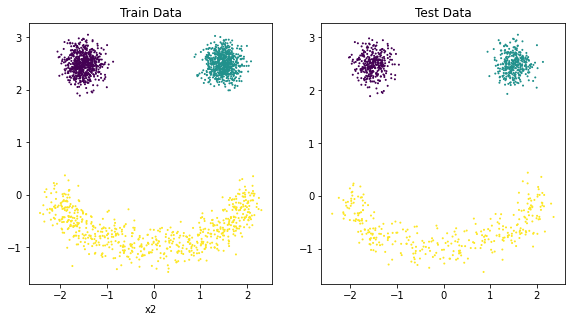

Dataset 2


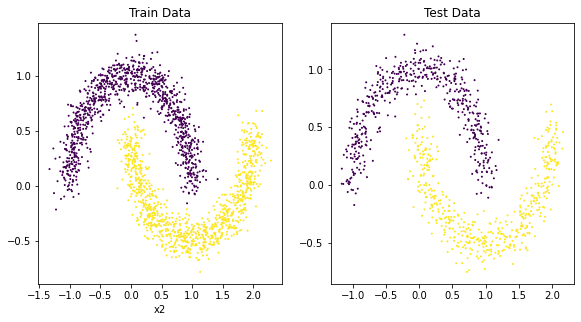

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import deepul.pytorch_util as ptu

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def train(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(device).float().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device).float().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in range(epochs):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)

        print(f"EPOCH {epoch}, test loss: {test_loss}")
            
    return train_losses, test_losses

In [86]:
class MLP(nn.Module):
    def __init__(self, out, hidden):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(2, hidden[0]))
        for i in range(len(hidden) - 1):
            self.layers.append(nn.Linear(hidden[i], hidden[i + 1]))
        self.out_layer = nn.Linear(hidden[-1], out)

    def forward(self, x):
        for l in self.layers:
            x = F.relu(l(x))
        return self.out_layer(x)
        

class Affine2D(nn.Module):

    def __init__(self, fix_dim, hidden):
        super().__init__()
        self.fix_dim = fix_dim
        self.param_nn = MLP(2, hidden)

        self.scale = nn.Parameter(torch.randn(1))
        self.scale_shift = nn.Parameter(torch.randn(1))
        if fix_dim == 0:
            self.mask = torch.FloatTensor([0.0, 1.0]).to(device)
        else:
            self.mask = torch.FloatTensor([1.0, 0.0]).to(device)

    def forward(self, x):
        # input: B * 2
        B = x.shape[0]
        # B * 2
        mask_ = self.mask.unsqueeze(0).repeat(B, 1)
        # B * 2
        x_ = x * (1.0 - mask_)

        # B * 2
        param = self.param_nn(x_)
        # B * 1
        mean, log_std = torch.chunk(param, 2, dim=1)
        # B * 1
        log_std = self.scale * torch.tanh(log_std) + self.scale_shift
        # B * 2       
        mean = mean * mask_
        # B * 2
        log_std_ = log_std * mask_
        # B * 2
        x = x * log_std_.exp() + mean
        # log_std is the log abs det dz/dx
        return x, log_std_

class RealNVP2D(nn.Module):
    def __init__(self, transformations):
        super().__init__()
        self.transformations = nn.ModuleList()
        for l in transformations:
            self.transformations.append(l)
        self.z_dist = Normal(torch.FloatTensor([0.0]).to(device),
                             torch.FloatTensor([1.0]).to(device)
                            )
    def forward(self, x):
        log_abs_det = torch.zeros(x.shape[0], 2).to(device)
        for l in self.transformations:
            x, log_std = l(x)
            log_abs_det += log_std
        return x, log_abs_det

    def loss(self, x):
        return -self.log_prob(x).mean()

    def log_prob(self, x):
        z, log_abs_det = self(x)
        log_prob = self.z_dist.log_prob(z) 
        ret = (log_prob.sum(dim=1) + log_abs_det.sum(dim=1))
        return ret

In [87]:
def q1_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in R^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    """ YOUR CODE HERE """
    # create data loaders
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(dataset=train_data, **loader_args)
    test_loader = data.DataLoader(dataset=test_data, **loader_args)
    # model
    model = RealNVP2D([Affine2D(0, [64, 64]),
                       Affine2D(1, [64, 64]),
                       Affine2D(0, [64, 64]),
                       Affine2D(1, [64, 64]),
                       Affine2D(0, [64, 64])])
    model.to(device)
    # train
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=100, lr=1e-3))
    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
    log_prob = model.log_prob(mesh_xs)
    densities = np.exp(ptu.get_numpy(log_prob))

    # latents
    with torch.no_grad():
      latents, _ = model(torch.FloatTensor(train_data).to(device))
      latents = latents.cpu().numpy()
    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



EPOCH 0, test loss: 3.7362422943115234
EPOCH 1, test loss: 3.7074878215789795
EPOCH 2, test loss: 3.586542844772339
EPOCH 3, test loss: 3.456454038619995
EPOCH 4, test loss: 3.235689878463745
EPOCH 5, test loss: 2.948077440261841
EPOCH 6, test loss: 2.6315627098083496
EPOCH 7, test loss: 2.40401291847229
EPOCH 8, test loss: 2.3635780811309814
EPOCH 9, test loss: 2.2547292709350586
EPOCH 10, test loss: 2.2811715602874756
EPOCH 11, test loss: 2.1495609283447266
EPOCH 12, test loss: 2.091892719268799
EPOCH 13, test loss: 2.0384271144866943
EPOCH 14, test loss: 2.0691182613372803
EPOCH 15, test loss: 2.0482113361358643
EPOCH 16, test loss: 1.9770925045013428
EPOCH 17, test loss: 1.9026899337768555
EPOCH 18, test loss: 1.8840668201446533
EPOCH 19, test loss: 1.86916983127594
EPOCH 20, test loss: 1.8690564632415771
EPOCH 21, test loss: 1.8084172010421753
EPOCH 22, test loss: 1.7743887901306152
EPOCH 23, test loss: 1.7834161520004272
EPOCH 24, test loss: 1.7518757581710815
EPOCH 25, test loss

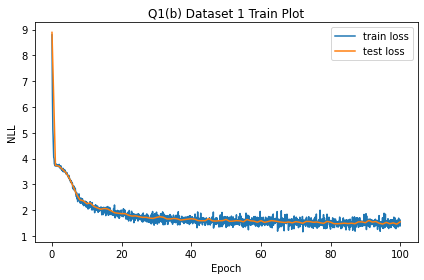

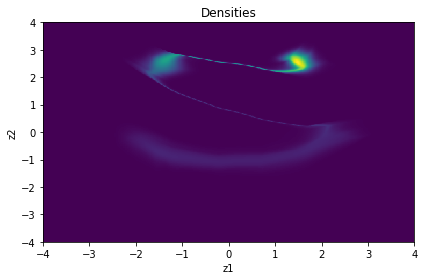

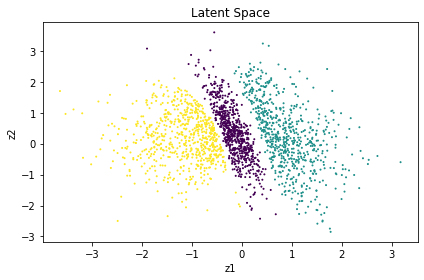

In [88]:
q1_save_results(1, 'b', q1_b)

EPOCH 0, test loss: 1.9567508697509766
EPOCH 1, test loss: 1.8306710720062256
EPOCH 2, test loss: 1.772886037826538
EPOCH 3, test loss: 1.731615424156189
EPOCH 4, test loss: 1.6747233867645264
EPOCH 5, test loss: 1.6176366806030273
EPOCH 6, test loss: 1.5724998712539673
EPOCH 7, test loss: 1.512237548828125
EPOCH 8, test loss: 1.526336431503296
EPOCH 9, test loss: 1.472297191619873
EPOCH 10, test loss: 1.4697799682617188
EPOCH 11, test loss: 1.4507559537887573
EPOCH 12, test loss: 1.4086463451385498
EPOCH 13, test loss: 1.4311081171035767
EPOCH 14, test loss: 1.3851101398468018
EPOCH 15, test loss: 1.3699275255203247
EPOCH 16, test loss: 1.3551326990127563
EPOCH 17, test loss: 1.3205281496047974
EPOCH 18, test loss: 1.3951228857040405
EPOCH 19, test loss: 1.3469936847686768
EPOCH 20, test loss: 1.334610939025879
EPOCH 21, test loss: 1.3100979328155518
EPOCH 22, test loss: 1.2875405550003052
EPOCH 23, test loss: 1.2898585796356201
EPOCH 24, test loss: 1.2959189414978027
EPOCH 25, test l

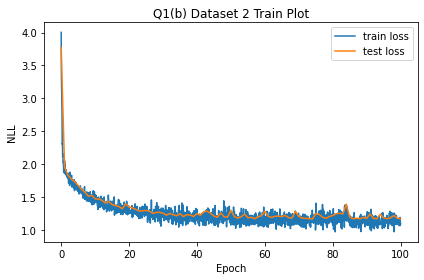

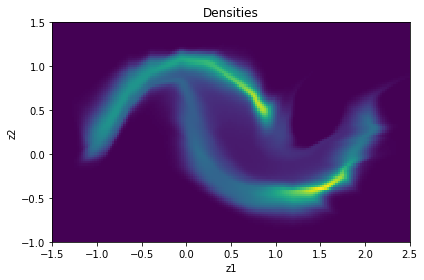

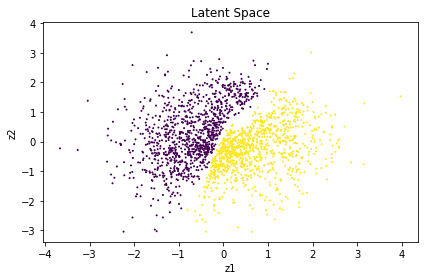

In [89]:
q1_save_results(2, 'b', q1_b)